<a href="https://colab.research.google.com/github/hyemin-lim/bear_classify/blob/main/tree_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [7]:
key = os.environ.get('AZURE_SEARCH_KEY', '2a024d679b2e45f799ec42bac4e3d337')

In [8]:
plant_types = 'succulent', 'cactus', 'tree'
path = Path('plants')

In [14]:
for o in plant_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [15]:
fns = get_image_files(path)
fns

(#441) [Path('plants/tree/00000092.jpg'),Path('plants/tree/00000051.jpg'),Path('plants/tree/00000108.jpg'),Path('plants/tree/00000144.jpg'),Path('plants/tree/00000010.jpg'),Path('plants/tree/00000009.jpg'),Path('plants/tree/00000147.jpg'),Path('plants/tree/00000074.jpg'),Path('plants/tree/00000022.jpg'),Path('plants/tree/00000054.jpg')...]

In [16]:
failed = verify_images(fns)
failed

(#9) [Path('plants/tree/00000114.jpg'),Path('plants/succulent/00000053.jpg'),Path('plants/succulent/00000072.jpg'),Path('plants/cactus/00000136.jpeg'),Path('plants/cactus/00000016.jpg'),Path('plants/cactus/00000049.jpg'),Path('plants/cactus/00000118.jpg'),Path('plants/cactus/00000089.jpg'),Path('plants/cactus/00000024.jpg')]

In [17]:
failed.map(Path.unlink);

In [18]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = plants.dataloaders(path)

In [23]:
plants = plants.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = plants.dataloaders(path)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.613321,0.901519,0.279070,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.704058,0.447230,0.127907,00:17
1,0.568727,0.402720,0.104651,00:17
2,0.450829,0.423161,0.116279,00:18
3,0.376987,0.433800,0.104651,00:18


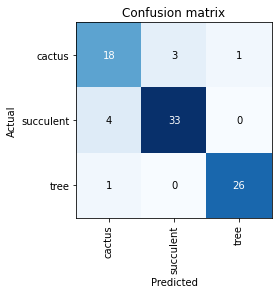

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

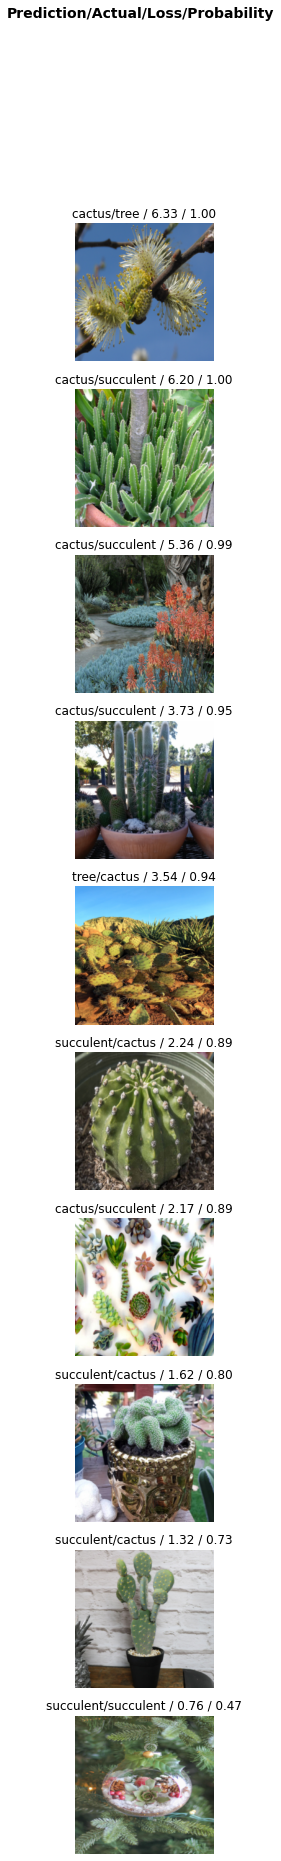

In [26]:
interp.plot_top_losses(10, nrows=10)

In [29]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [33]:
learn_inf = load_learner(path/'export.pkl')

In [35]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

In [40]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: tree; Probability: 0.9994')

In [41]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [45]:
#hide_output
VBox([widgets.Label('Select your plant!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 